In [2]:
pip install shap

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import copy

## Load data to fit "ground truth" curves

In [4]:
bat_dict = pickle.load(open('/content/bat_dict_small.pkl', 'rb'))

In [5]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [6]:
params = []
cycle_lives = []
#pred_cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])

    cycle_lives.append(bat["cycle_life"][0])
    #pred_cycle_lives.append([np.power(np.exp(-alpha)*(0.2-gamma),1/beta)])
params = np.array(params)
cycle_lives = np.array(cycle_lives)
#pred_cycle_lives = np.array(pred_cycle_lives)

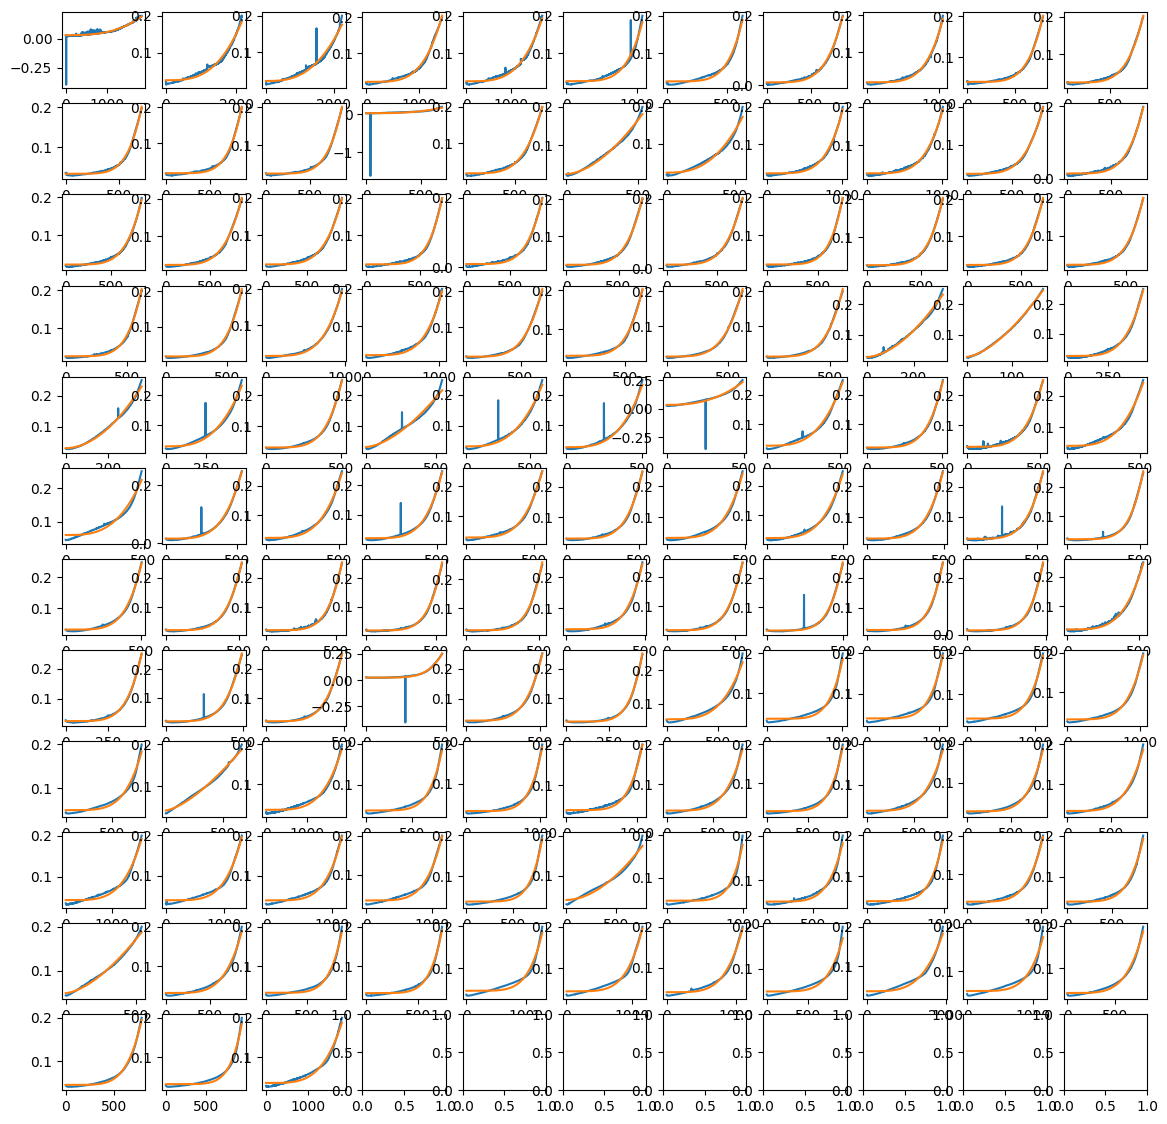

In [7]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

## Load data for predictive model

In [8]:
# features4 uses Severson interpolated data AND takes the log of all statistical features
# can try features3, which still uses Severson data but without the log of min, mean, skew kurtosis
data = np.loadtxt('/content/features4.csv',delimiter=',',skiprows=1) # skip row for column names

In [9]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [62]:
# logVar, logMean, logMin, logSkew, logKurtosis
x_train = data[:,[1,2,3]][train_ind]
y_train = params[train_ind]
life_train = cycle_lives[train_ind]

x_test = data[:,[1,2,3]][test_ind]
y_test = params[test_ind]
life_test = cycle_lives[test_ind]

x_stest = data[:,[1,2,3]][secondary_ind]
y_stest = params[secondary_ind]
life_stest = cycle_lives[secondary_ind]

In [63]:
x_train

array([[-5.01395962, -1.95845666, -1.95845666],
       [-4.44261336, -1.7221493 , -1.7221493 ],
       [-4.17887796, -1.59896533, -1.59896533],
       [-3.81348608, -1.41755723, -1.41755723],
       [-4.14689653, -1.6254072 , -1.6254072 ],
       [-4.0179491 , -1.53843313, -1.53843313],
       [-3.97015945, -1.50768716, -1.50768716],
       [-3.61990683, -1.33825645, -1.33825645],
       [-3.35033805, -1.18895973, -1.18895973],
       [-3.93866252, -1.49699783, -1.49699783],
       [-3.79522   , -1.4161842 , -1.4161842 ],
       [-3.84471181, -1.42929971, -1.42929971],
       [-3.74469922, -1.3891761 , -1.3891761 ],
       [-3.6464635 , -1.34135637, -1.34135637],
       [-3.84861616, -1.42924531, -1.42924531],
       [-3.66950134, -1.35045675, -1.35045675],
       [-3.43304817, -1.24860081, -1.24860081],
       [-4.0552127 , -1.53617106, -1.53617106],
       [-3.66585579, -1.34959877, -1.34959877],
       [-3.42070001, -1.2306443 , -1.2306443 ],
       [-2.74571314, -0.86830926, -0.868

In [64]:
train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest))

In [65]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads

        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B):
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output

    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output

    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back)
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

    def model_wrapper(self,inputs):
      predictions = []
      for input_data in inputs:
          input_tensor = torch.tensor(input_data, dtype=torch.float32)  # Assuming input_data is a NumPy array
          prediction = self.forward(input_tensor)
          predictions.append(prediction.detach().numpy())  # Assuming 'prediction' is a PyTorch tensor
      return np.array(predictions)

    def predict(self,array_X):
       input_tensor = torch.tensor(array_X, dtype=torch.float32)
       prediction = self.forward(input_tensor)
       return prediction.detach().numpy()


In [66]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [67]:
d_model = 2
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 0
nepoch = 500
lr = 1e-3
batch_size = 1

n = 10 # number of points at which to compare predicted curve with fitted curve
x = torch.Tensor(np.arange(1,n))
weights = torch.tensor([1/32,1/4,1/0.02]) # used to normalize magnitudes of parameters

In [68]:
class weighted_MSELoss(nn.Module):
    '''calculates MSE of scaled/normalized parameters'''
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.mean( torch.mul(((inputs - targets)**2 ), weights) )

In [69]:
model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=3,attn_model=attn_model,skip_connect=skip_connect)
criterion = weighted_MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, true_life = batch
        output = model(train_input.to(device))

        fit_curve = torch.exp(train_label[:,0])*torch.pow(x*(true_life/n),train_label[:,1])+train_label[:,2]
        pred_curve = torch.exp(output[:,0])*torch.pow(x*(true_life/n),output[:,1])+output[:,2]
        #loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))

        # calc loss as a linear combination of difference between curves and MSE loss of parameters
        loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x)))) + 0.75*criterion(output,train_label,weights)
        #loss = criterion(output, train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model(test_input.to(device))
        fit_curve = torch.exp(test_label[:,0])*torch.pow(x*(true_life/n),test_label[:,1])+test_label[:,2]
        pred_curve = torch.exp(test_output[:,0])*torch.pow(x*(true_life/n),test_output[:,1])+test_output[:,2]
        test_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))
        #test_loss = criterion(test_output, test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model(stest_input.to(device))
        fit_curve = torch.exp(stest_label[:,0])*torch.pow(x*(true_life/n),stest_label[:,1])+stest_label[:,2]
        pred_curve = torch.exp(stest_output[:,0])*torch.pow(x*(true_life/n),stest_output[:,1])+stest_output[:,2]
        stest_loss = criterion(fit_curve,pred_curve,torch.Tensor(np.ones(len(x))))
        #stest_loss = criterion(stest_output, stest_label)

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0:
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 50 | rmse:  3.968 | rmse_test:  2.479 | rmse_stest:  1.752
Epochs: 100 | rmse:  3.161 | rmse_test:  1.254 | rmse_stest:  0.797
Epochs: 150 | rmse:  2.945 | rmse_test:  0.725 | rmse_stest:  0.421
Epochs: 200 | rmse:  2.867 | rmse_test:  0.434 | rmse_stest:  0.230
Epochs: 250 | rmse:  2.825 | rmse_test:  0.265 | rmse_stest:  0.128
Epochs: 300 | rmse:  2.775 | rmse_test:  0.152 | rmse_stest:  0.060
Epochs: 350 | rmse:  2.664 | rmse_test:  0.087 | rmse_stest:  0.033
Epochs: 400 | rmse:  2.399 | rmse_test:  0.068 | rmse_stest:  0.034
Epochs: 450 | rmse:  1.906 | rmse_test:  0.091 | rmse_stest:  0.098
Epochs: 500 | rmse:  1.315 | rmse_test:  0.107 | rmse_stest:  0.129


209.34129291369152
262.0189520095867
305.5938949655918


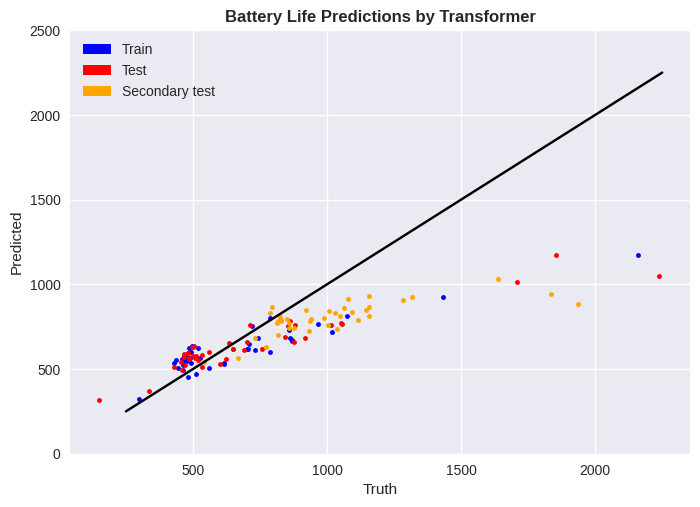

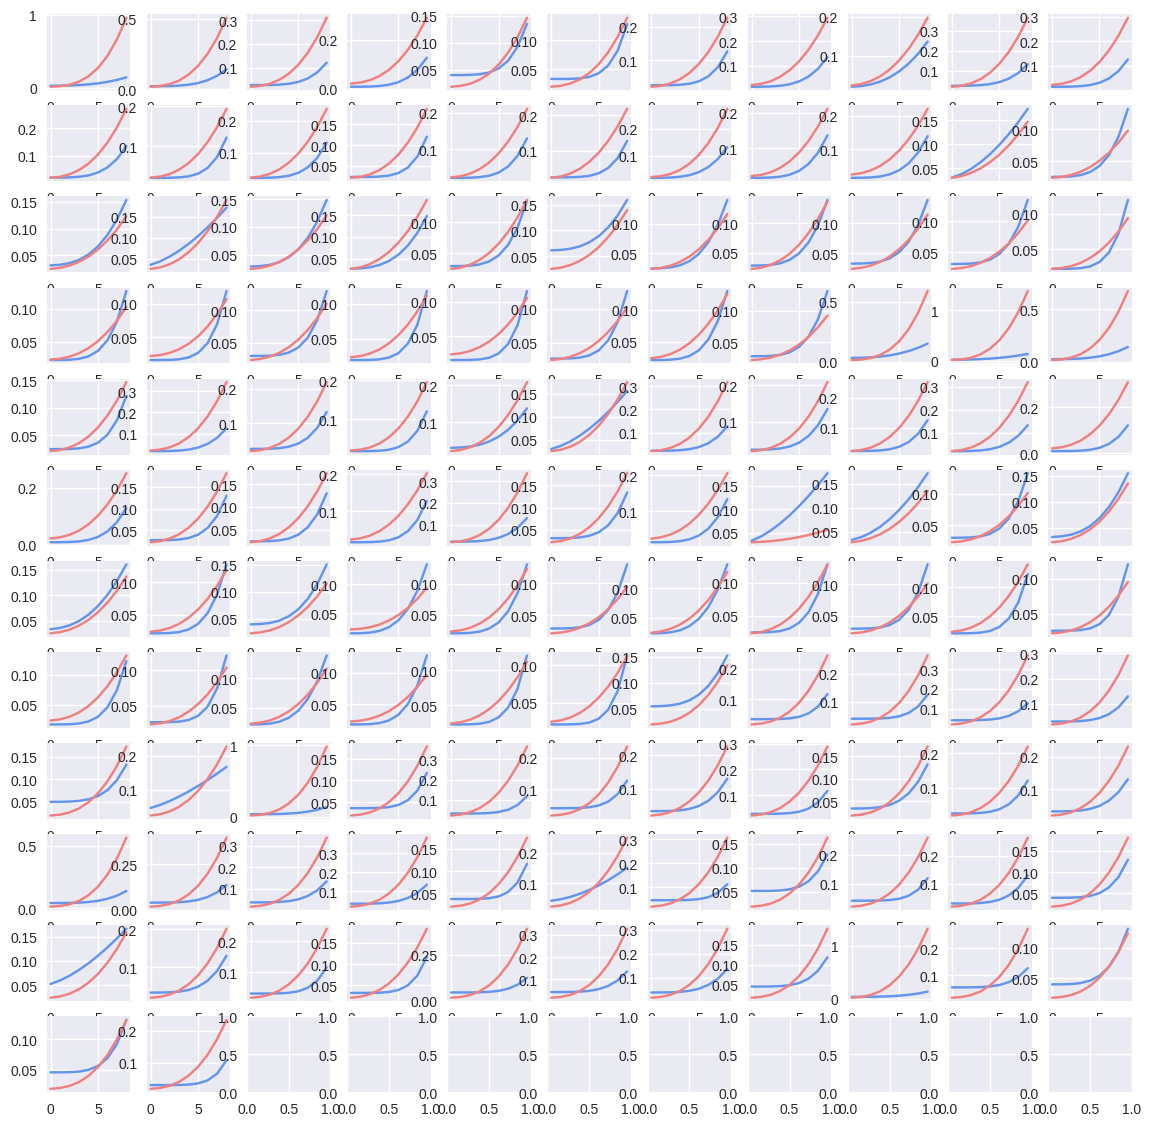

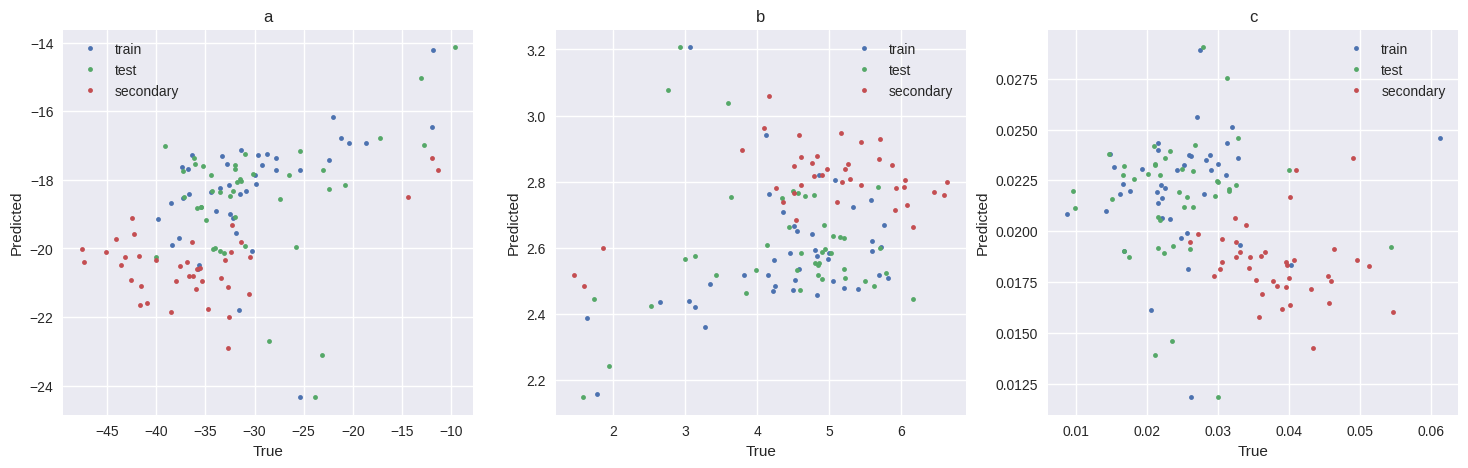

In [70]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
ix = 0

for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+label[2]
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+pred[2]

        # plot predicted vs. ground truth curves
        ax_curve = axs_curve[int(ix/11)][ix%11]
        ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
        ax_curve.plot(pred_curve, color="lightcoral")
        ix+=1

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

# plot predicted vs. actual cycle lives
ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

# plot predicted vs. ground truth model parameters
for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

## Second round of training (calc loss w/ cycle lifetime)

In [71]:
# create a deep copy of model to fine tune
model2 = copy.deepcopy(model)

In [72]:
# low learning rate and many epochs for fine-tuning
lr_fine = 1e-6
optimizer_fine = torch.optim.Adam(model2.parameters(), lr=lr_fine)
nepoch = 3000
criterion = nn.MSELoss().to(device)

In [73]:
# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life = batch
        output = model2(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life):
            print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life[:,0])
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model2(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life[:,0])

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model2(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life[:,0])

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0:
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 100 | rmse:  203.352 | rmse_test:  255.284 | rmse_stest:  291.782
Epochs: 200 | rmse:  198.860 | rmse_test:  250.048 | rmse_stest:  280.282
Epochs: 300 | rmse:  195.571 | rmse_test:  246.052 | rmse_stest:  270.864
Epochs: 400 | rmse:  193.244 | rmse_test:  243.041 | rmse_stest:  263.256
Epochs: 500 | rmse:  191.609 | rmse_test:  240.749 | rmse_stest:  257.062
Epochs: 600 | rmse:  190.482 | rmse_test:  239.064 | rmse_stest:  252.222
Epochs: 700 | rmse:  189.693 | rmse_test:  237.759 | rmse_stest:  248.261
Epochs: 800 | rmse:  189.142 | rmse_test:  236.768 | rmse_stest:  245.116
Epochs: 900 | rmse:  188.742 | rmse_test:  236.015 | rmse_stest:  242.655
Epochs: 1000 | rmse:  188.453 | rmse_test:  235.422 | rmse_stest:  240.685
Epochs: 1100 | rmse:  188.231 | rmse_test:  234.949 | rmse_stest:  239.116
Epochs: 1200 | rmse:  188.051 | rmse_test:  234.555 | rmse_stest:  237.825
Epochs: 1300 | rmse:  187.910 | rmse_test:  234.235 | rmse_stest:  236.813
Epochs: 1400 | rmse:  187.776 | rm

186.08666551502503
41
41
231.5186576069078
43
43
231.79049502858194
39
39


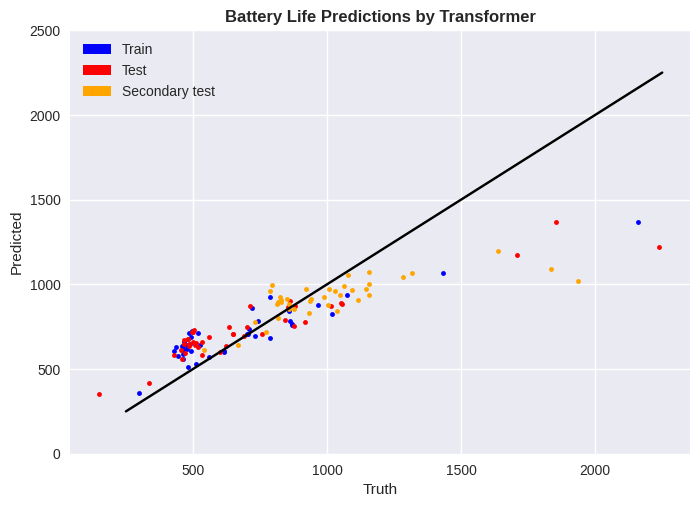

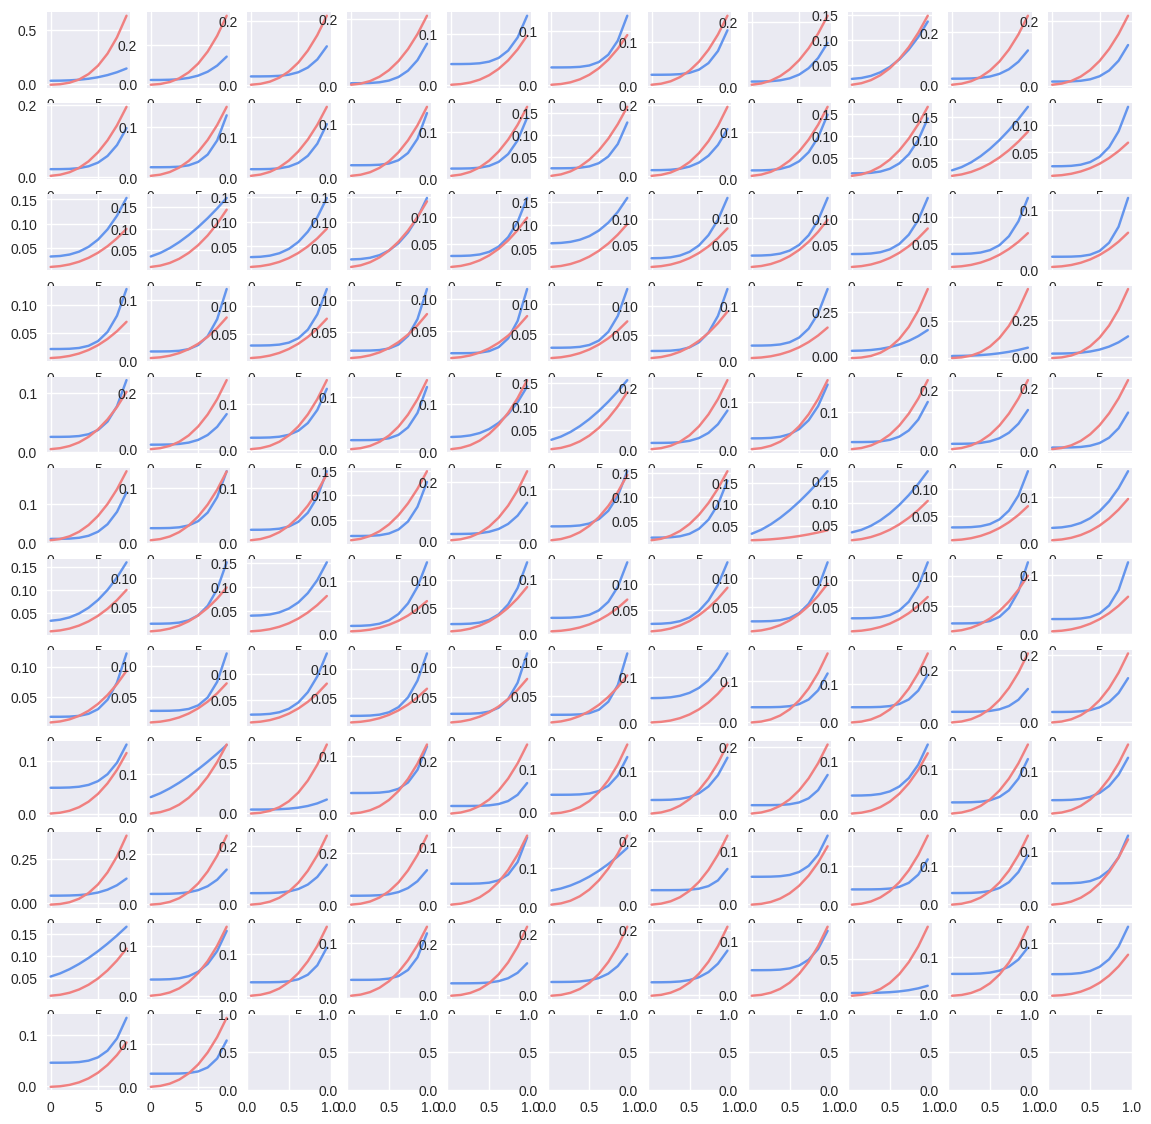

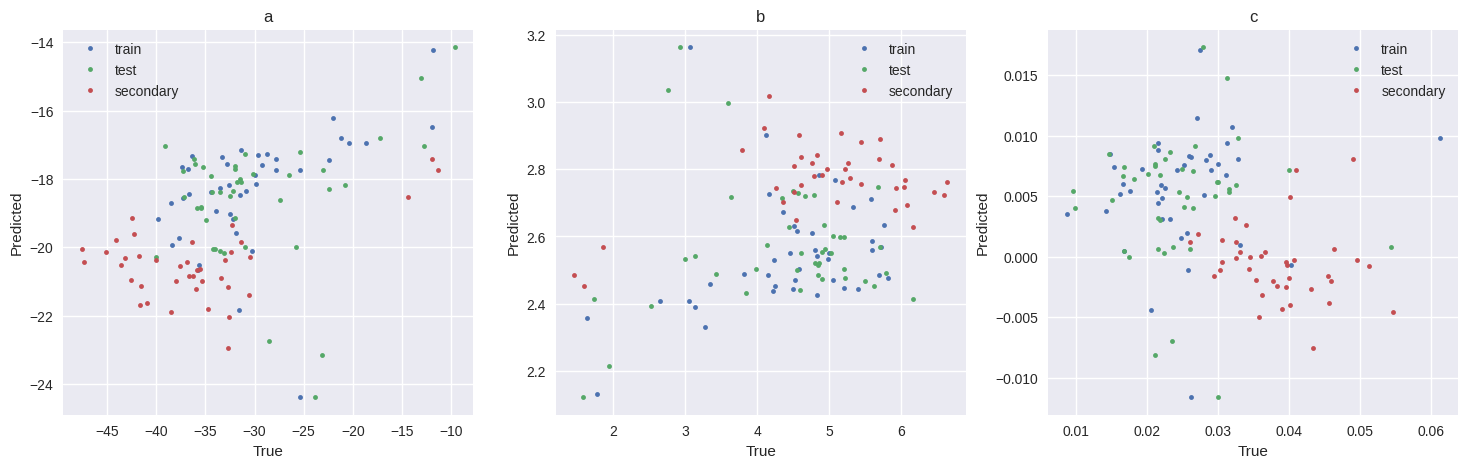

In [74]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch
np.set_printoptions(suppress=True)

fig, ax = plt.subplots()
fig_curve,axs_curve=plt.subplots(nrows=12,ncols=11,figsize=(14,14))

colors = ["blue","red","orange"]
parameter_results = {0:[[], []], 1:[[], []], 2:[[], []]}
ix = 0

for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model2(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])
        parameter_results[i][0].append(label.detach().numpy())
        parameter_results[i][1].append(pred)
        predicted.append(pred_life)
        labels.append(true_life[0])

        fit_curve = torch.exp(label[0])*torch.pow(x*(true_life/n),label[1])+label[2]
        pred_curve = np.exp(pred[0])*np.power(x*(true_life/n),pred[1])+pred[2]

        # plot predicted vs. ground truth curves
        ax_curve = axs_curve[int(ix/11)][ix%11]
        ax_curve.plot(fit_curve.detach().numpy(), color="cornflowerblue")
        ax_curve.plot(pred_curve, color="lightcoral")
        ix+=1

    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))
    ax.plot(labels, predicted, ".",color=colors[i])
    print(len(labels))
    print(len(predicted))
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

# plot predicted vs. actual cycle lives
ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.show()

# plot predicted vs. ground truth model parameters
for i in range(3):
    parameter_results[i][0] = np.array(parameter_results[i][0])
    parameter_results[i][1] = np.array(parameter_results[i][1])

plt.rcParams["figure.figsize"] = (18, 5)
fig, axs = plt.subplots(1, 3)
for i, title in zip(range(3), ["a", "b", "c"]):
    axs[i].set_title(title)
    for j, lab in zip(range(3), ["train", "test", "secondary"]):
        axs[i].plot(parameter_results[j][0][:, i], parameter_results[j][1][:, i], ".", label = lab)
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")
    axs[i].legend()
plt.show()

## **SHAP**

### **Deep Explainer**

In [75]:
import shap
explainer = shap.DeepExplainer(model2,torch.Tensor(x_train))
shap_values = explainer.shap_values(torch.Tensor(x_train))

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [82]:
np.array(shap_values).shape

(3, 41, 3)

In [76]:
shap_values[0][0]

array([-6.07073736,  0.00009863,  0.00009863])

In [ ]:
# instance_index = 0  # You can choose any index from your training set
# instance = torch.Tensor(x_train[instance_index])

# # Compute SHAP values for the chosen instance
# shap_values = explainer.shap_values(instance)

# # Create an Explanation object for the chosen instance
# explanation = shap.Explanation(shap_values[0][instance_index])  # Replace feature_names

# # Create a waterfall plot for the chosen instance's SHAP values
# shap.plots.waterfall(explanation, max_display=10)

# # Show the plot
# shap.initjs()

In [ ]:
# explanation = shap.Explanation(shap_values[0])  # Replace feature_names

# # Create a waterfall plot for the chosen instance
# shap.plots.waterfall(explanation, max_display=10)

# # Show the plot
# shap.initjs()

### **Kernel Explainer**

In [84]:
import shap
explainer = shap.KernelExplainer(model2.predict,(x_train))
shap_values = explainer.shap_values(x_train)

  0%|          | 0/41 [00:00<?, ?it/s]

In [85]:
arr = np.array(shap_values)

In [86]:
arr.shape

(3, 41, 3)

In [87]:
instance_index = 0  # You can choose any index from your training set
instance = torch.Tensor(x_train[instance_index:instance_index+1, :])  # Get the specific instance as a single-row matrix
# Compute SHAP values for the chosen instance
shap_values_single = explainer.shap_values(instance)

AssertionError: ignored

In [ ]:
print(instance)

In [ ]:
shap_values_single

### Summary Plot

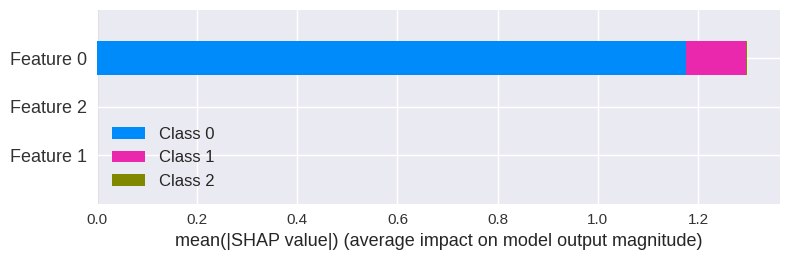

In [88]:
shap.summary_plot(shap_values, x_train)

### Waterfall

In [ ]:
# for label_idx in range(len(shap_values)):  #alpha,beta,gamma
#     for instance_idx in range(len(shap_values[label_idx])):
#         explanation = shap.Explanation(shap_values[label_idx][instance_idx])  # Replace feature_names
#         print(explanation)
#         print(f"Label: {label_idx}, Instance: {instance_idx}")
#         shap.plots.waterfall(explanation, max_display=10)
#         break